This notebook was ran on a Google Cloud Workbench jupyter notebook instance with a Free Tier n2-highmem-8 (8 vCPUs, 64GB RAM) machine.

### Note

All data used are available here : https://github.com/boudinfl/ake-datasets

We recall that :
- Each document has a title and an abstract, which will serve as **INPUT**.
- Each document has a list of keywords, which will serve as **OUTPUT**.
    - Documents provide different types for **OUTPUT**, such as author-keywords and reader-keywords.
    - Each keyword contains one or many words. (n.b. the words may or may not be present in the text input)

After analysis of each dataset, we will be collecting the following features :
- **DATASET_ID** : name of the dataset + subcategory of outputs, e.g. 'inspec_controlled' or 'inspec_uncontrolled'
- **TEXT_ID** : unique identifier of the document inside the dataset, e.g. 'train_001' or 'test_001'
- **INPUT** : tokenization and concatenation of all sentences using RegexpTokenizer from nltk; lower-cased; each word is tokenized, e.g. "pre-processing" -> \["pre", "processing"\] -> "pre processing".
- **OUTPUT** : concatenation of keywords separated by a semicolon; lower-cased; not stemmed.

In [1]:
%cd /home/jupyter
!pip install -r requirements.txt
!git clone "https://github.com/boudinfl/ake-datasets/"
%cd /home/jupyter/notebooks

/home/jupyter
Cloning into 'ake-datasets'...
remote: Enumerating objects: 17994, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 17994 (delta 1), reused 3 (delta 1), pack-reused 17988
Receiving objects: 100% (17994/17994), 1.01 GiB | 10.87 MiB/s, done.
Resolving deltas: 100% (15194/15194), done.
Updating files: 100% (16235/16235), done.
/home/jupyter/notebooks


In [2]:
from xml.dom.minidom import parse
import matplotlib.pyplot as plt
from collections import Counter 
from os import listdir
import pandas
import numpy
import json

with open('/home/jupyter/setup.json', 'r') as file:
    variables = json.load(file)

if variables['USE_GCP'] != "false":
    from google.cloud import bigquery
    client = bigquery.Client(
        project = variables['PROJECT_ID'], 
        location = variables['REGION']
    )

In [3]:
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

tokenizer = RegexpTokenizer(r'\w+')
stemmer = PorterStemmer()

path = '/home/jupyter/ake-datasets/datasets'

## Table of Contents
* [Inspec](#inspec)
    * [Importing dataset](#inspecA)
    * [Explanatory Data Analysis](#inspecB)
    * [Exporting dataset](#inspecC)
* [SemEval-2010](#semeval)
    * [Importing dataset](#semevalA)
    * [Explanatory Data Analysis](#semevalB)
    * [Exporting dataset](#semevalC)
* [TermITH-Eval](#termith)
    * [Importing dataset](#termithA)
    * [Explanatory Data Analysis](#termithB)
    * [Exporting dataset](#termithC)

# Inspec<a class="anchor" id="inspec"></a>
### Importing dataset<a class="anchor" id="inspecA"></a>

In [4]:
dataset = 'Inspec'
folders = ['dev', 'train', 'test']
subsets = ['controlled', 'uncontrolled']
remove_words = ['-rrb-', '-lrb-', '-lsb-', '-rsb-', '-lcb-', '-rcb-', '', ' ']

In [5]:
table_input = pandas.DataFrame()
for folder in folders :
    for file in sorted(listdir(f"{path}/{dataset}/{folder}")) :
        try :
            if '.xml' in file :
                document = parse(f"{path}/{dataset}/{folder}/{file}")
                text_input = ('. '.join([
                    ' '.join([
                        ' '.join([
                            subword for subword in tokenizer.tokenize(word.firstChild.nodeValue.lower())
                        ])
                        for word in sentence.getElementsByTagName('word') if word.firstChild.nodeValue.lower() not in remove_words
                    ]) 
                    for sentence in document.getElementsByTagName('sentence')
                ]) + '.').replace('  ', ' ').replace(' .', '.')

                table_input = pandas.concat([table_input,
                                       pandas.DataFrame({'dataset_id' : [f"{dataset.lower()}"],
                                                         'text_id' : [f"{folder}_{file.split('.xml')[0].replace('-','_')}"],
                                                         'input' : [text_input]})])
        except Exception as e :
            print('File:', file, 'has error:', e)
table_input = table_input.drop_duplicates().reset_index(drop=True)
table_input

,dataset_id,text_id,input
0,inspec,dev_1461,adaptive multiresolution approach for solution...
1,inspec,dev_1462,non linear analysis of nearly saturated porous...
2,inspec,dev_1463,computational complexity of probabilistic disa...
3,inspec,dev_1464,lr parsing for conjunctive grammars. the gener...
4,inspec,dev_1465,p systems with symport antiport rules the trac...
...,...,...,...
1995,inspec,test_410,lossy spice models produce realistic averaged ...
1996,inspec,test_411,cad cae software aids converter design dc dc p...
1997,inspec,test_412,using virtual reality to teach disability awar...
1998,inspec,test_413,effects of white space in learning via the web...


In [6]:
table_output = pandas.DataFrame()
for folder in folders :
    for subset in subsets :
        keywords = {}
        with open(f'{path}/{dataset}/references/{folder}.{subset.split("olled")[0]}.json') as references_file :
            keywords.update(json.load(references_file))

        for key in keywords.keys() :
            keywords[key] = ';'.join([' '.join([subword.lower() for subword in tokenizer.tokenize(keyword) if subword not in remove_words and subword.isalpha()]) for keyword in [keyphrase[0] for keyphrase in keywords[key]]])
            table_output = pandas.concat([table_output,
                               pandas.DataFrame({'dataset_id' : [f"{dataset.lower()}"],
                                                 'subset_id' : [f"{subset}"],
                                                 'text_id' : [f"{folder}_{key.replace('-','_')}"],
                                                 'output' : [keywords[key]]})])
table_output = table_output.drop_duplicates().reset_index(drop=True)
table_output

,dataset_id,subset_id,text_id,output
0,inspec,controlled,dev_1461,hyperbolic equations;numerical stability;parti...
1,inspec,controlled,dev_1462,compressibility;elastic deformation;finite ele...
2,inspec,controlled,dev_1463,computational complexity;grammars
3,inspec,controlled,dev_1464,computational linguistics;context free grammar...
4,inspec,controlled,dev_1465,computational linguistics;grammars
...,...,...,...,...
3995,inspec,uncontrolled,test_410,lossy spice models;realistic averaged simulati...
3996,inspec,uncontrolled,test_411,dc dc power convertor design;power supply desi...
3997,inspec,uncontrolled,test_412,virtual reality;disability awareness teaching;...
3998,inspec,uncontrolled,test_413,white space features;web based instruction;pre...


### Explanatory Data Analysis<a class="anchor" id="inspecB"></a>

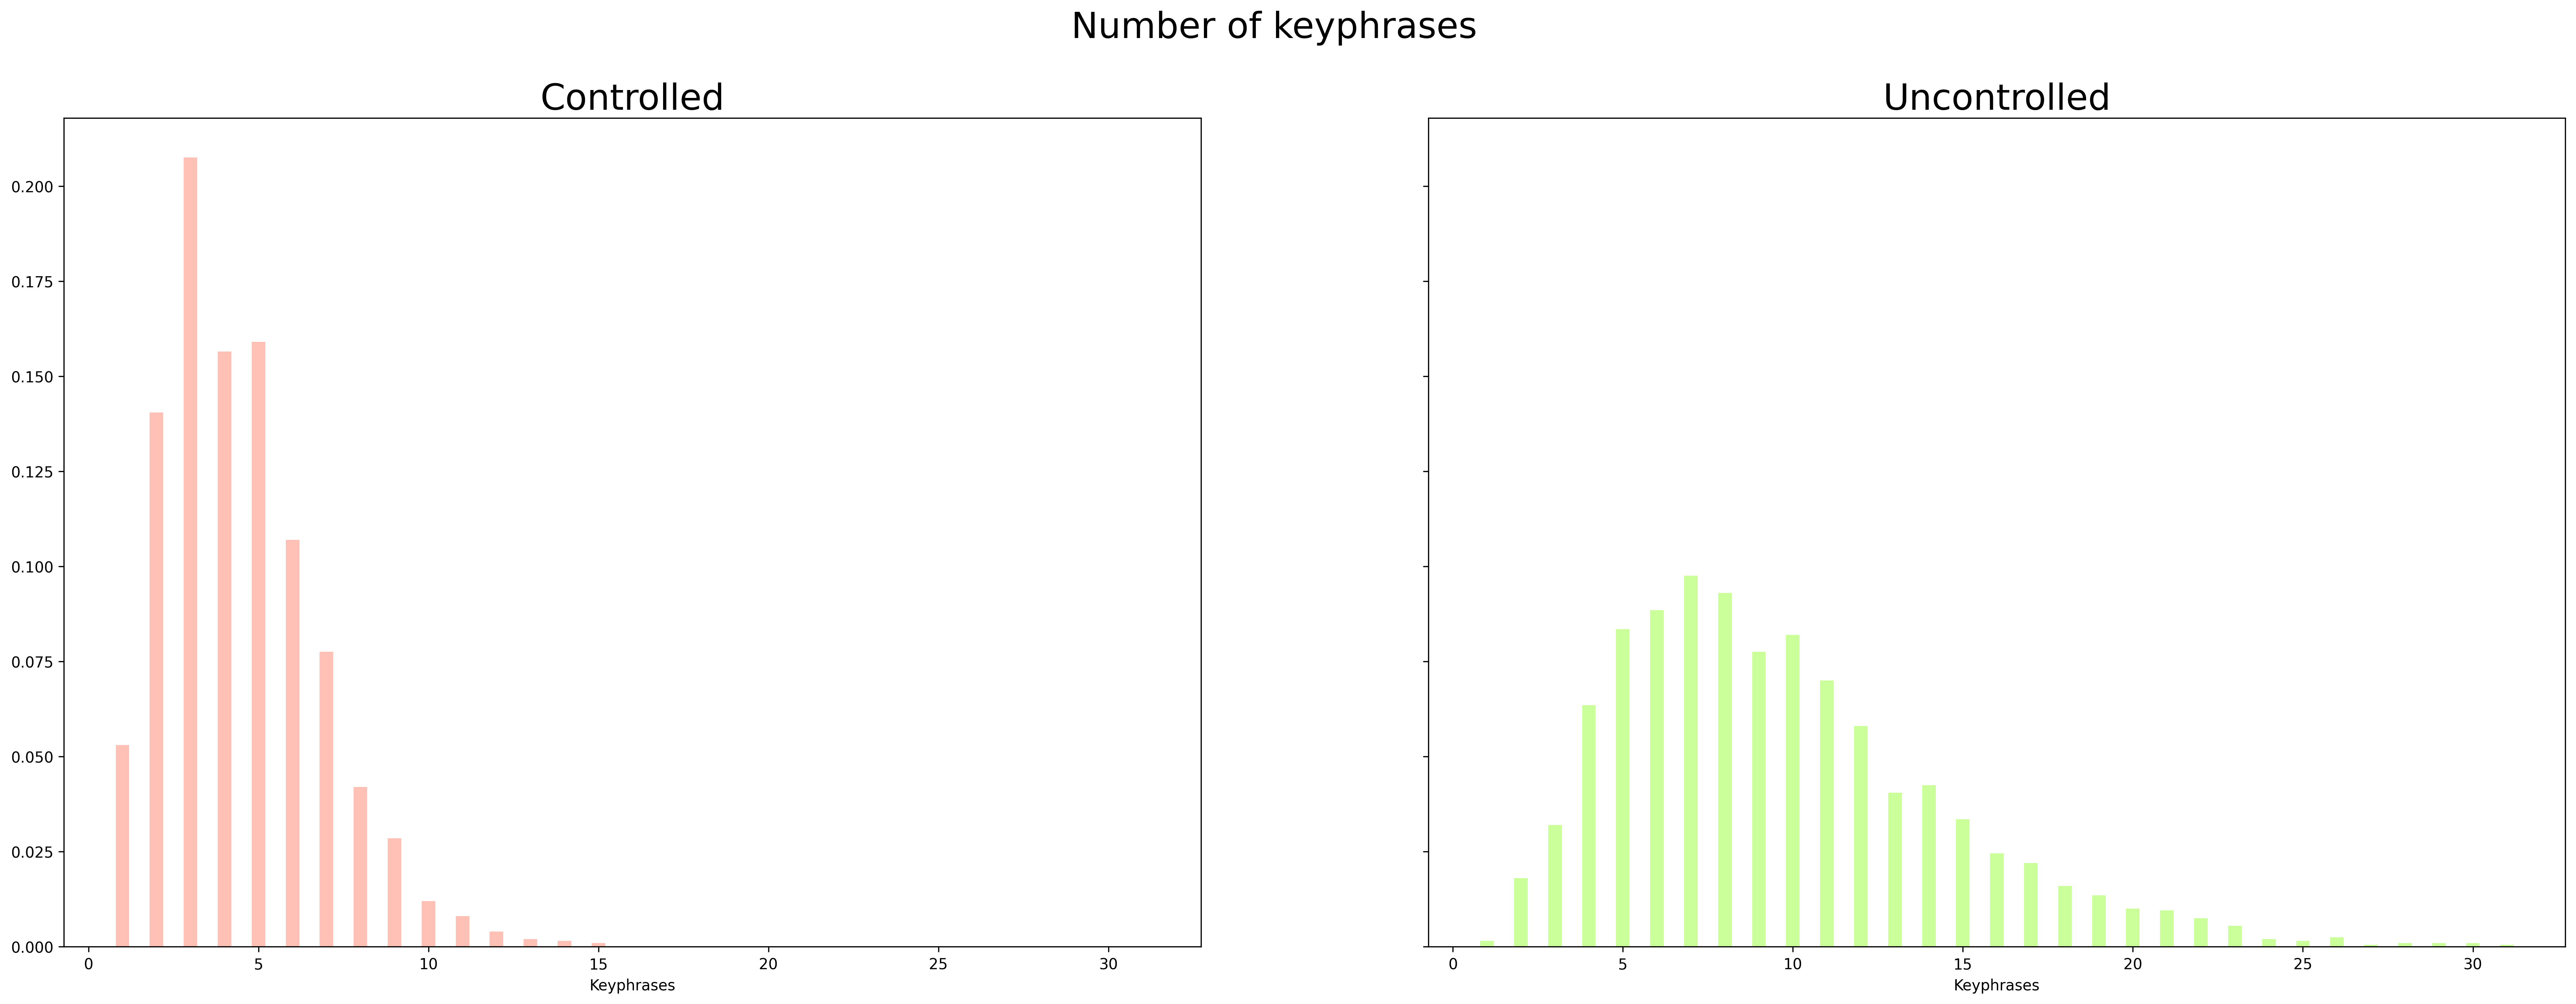

In [7]:
x_contr = Counter([len(keyphrase.split(';')) for keyphrase in table_output.loc[table_output['subset_id'] == 'controlled', 'output']])
x_uncontr = Counter([len(keyphrase.split(';')) for keyphrase in table_output.loc[table_output['subset_id'] == 'uncontrolled', 'output']])

n_contr = sum(x_contr.values())
n_uncontr = sum(x_uncontr.values())

figure, axis = plt.subplots(nrows = 1, ncols = 2, figsize = (30, 10), dpi = 300, sharey = True, sharex = True)
plt.rcParams.update({'font.size': 20})

axis[0].bar(x_contr.keys(), [x / n_contr for x in x_contr.values()], 0.4, alpha = 0.4, color = 'tomato', label = 'controlled')
axis[1].bar(x_uncontr.keys(), [x / n_uncontr for x in x_uncontr.values()], 0.4, alpha = 0.4, color = 'chartreuse', label = 'uncontrolled')

axis[0].set_xlabel('Keyphrases')
axis[1].set_xlabel('Keyphrases')

axis[0].set_title('Controlled')
axis[1].set_title('Uncontrolled')
figure.suptitle('Number of keyphrases')

plt.show()

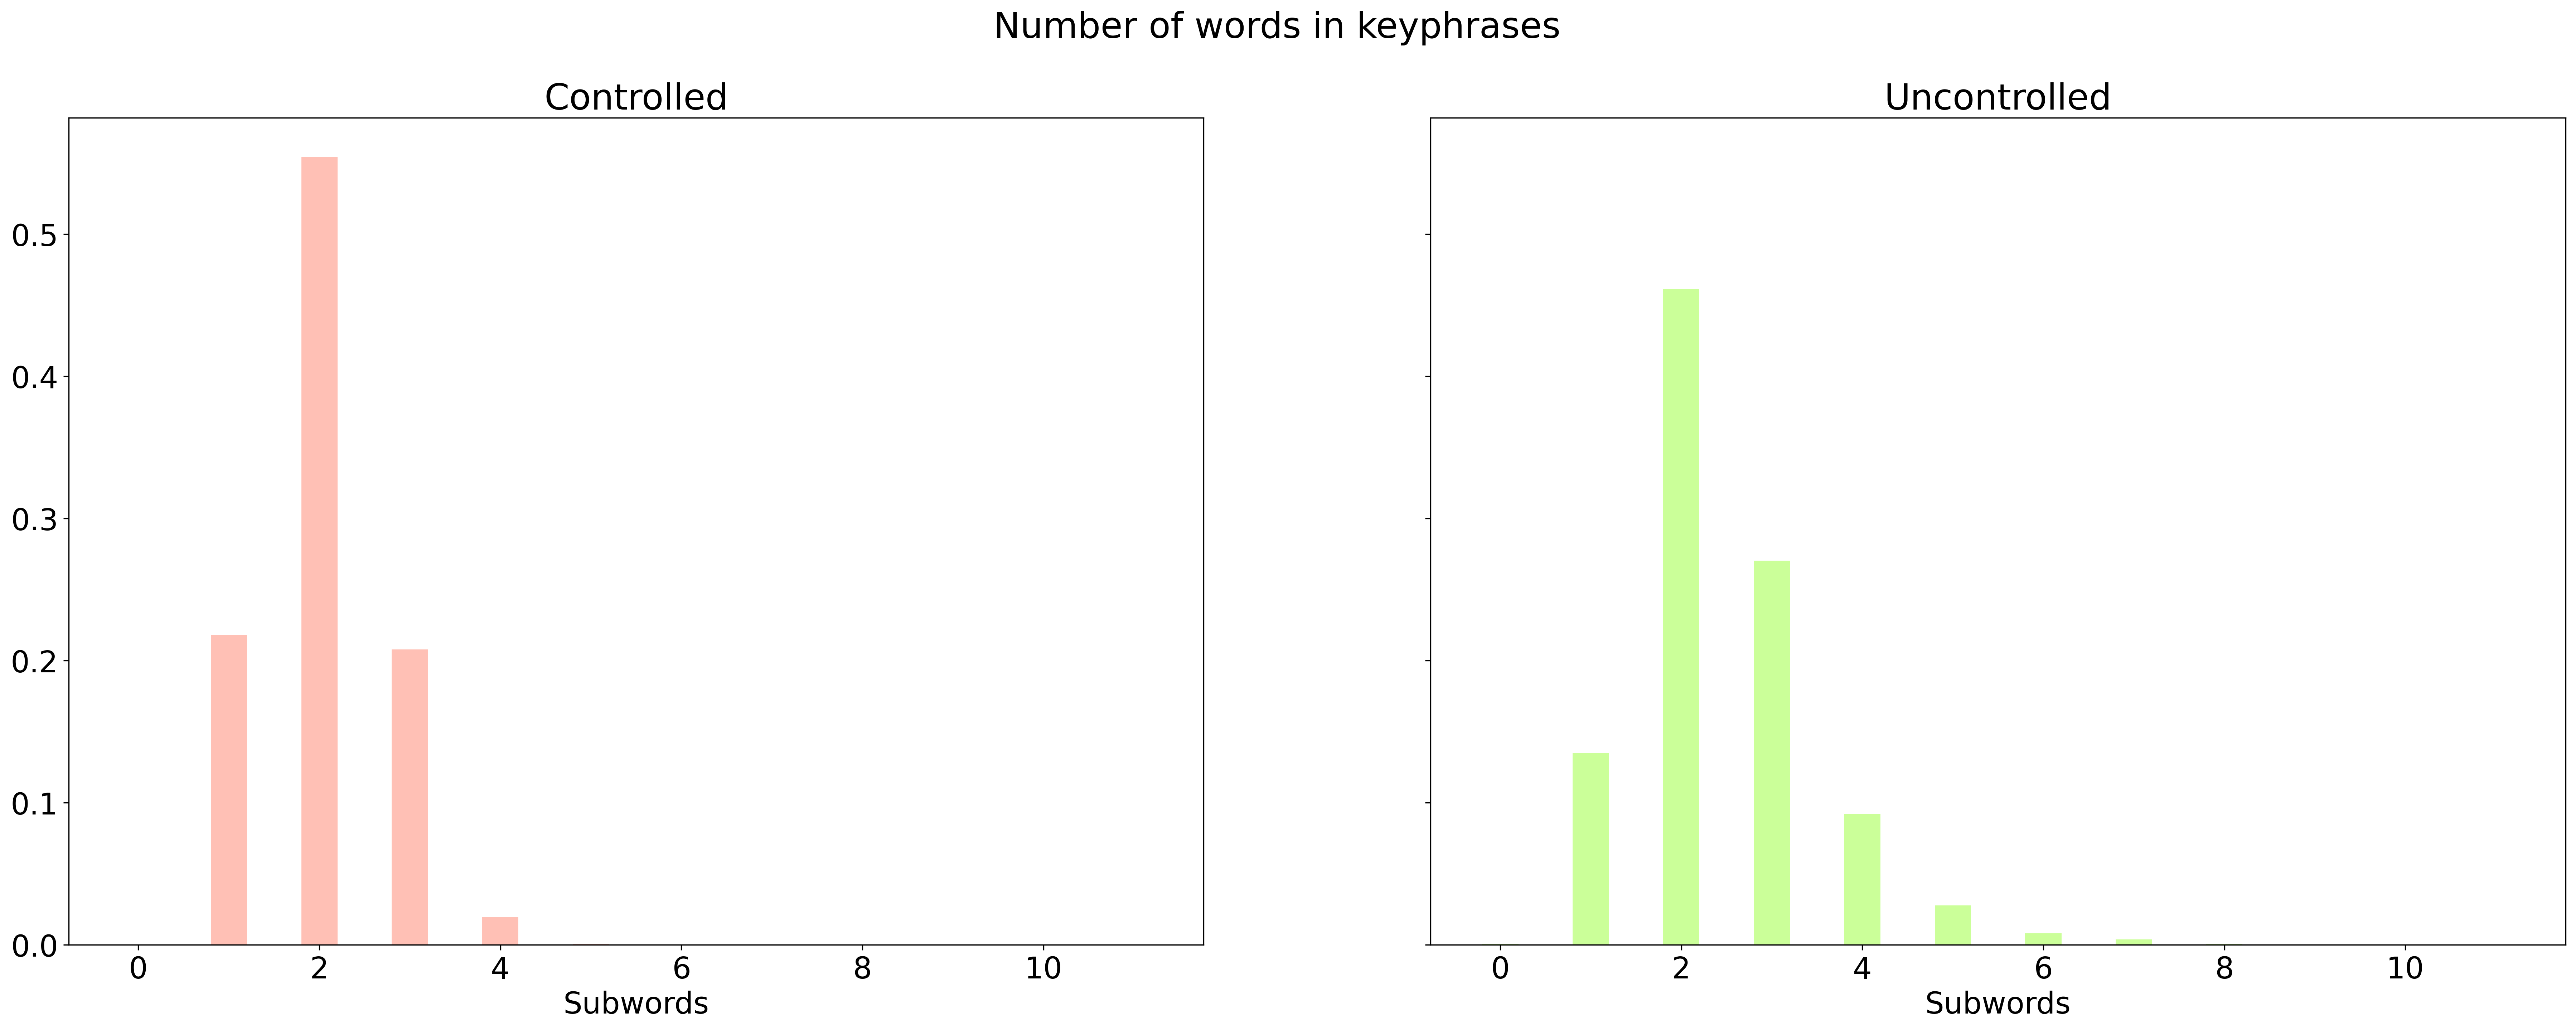

In [8]:
x_contr = Counter([len([word for word in keyword.split()]) for keyphrase in table_output.loc[table_output['subset_id'] == 'controlled', 'output'] for keyword in keyphrase.split(';') ])
x_uncontr = Counter([len([word for word in keyword.split()]) for keyphrase in table_output.loc[table_output['subset_id'] == 'uncontrolled', 'output'] for keyword in keyphrase.split(';') ])

n_contr = sum(x_contr.values())
n_uncontr = sum(x_uncontr.values())

figure, axis = plt.subplots(nrows = 1, ncols = 2, figsize = (30, 10), dpi = 300, sharey = True, sharex = True)
plt.rcParams.update({'font.size': 20})

axis[0].bar(x_contr.keys(), [x / n_contr for x in x_contr.values()], 0.4, alpha = 0.4, color = 'tomato', label = 'controlled')
axis[1].bar(x_uncontr.keys(), [x / n_uncontr for x in x_uncontr.values()], 0.4, alpha = 0.4, color = 'chartreuse', label = 'uncontrolled')

axis[0].set_xlabel('Subwords')
axis[1].set_xlabel('Subwords')

axis[0].set_title('Controlled')
axis[1].set_title('Uncontrolled')
figure.suptitle('Number of words in keyphrases')

plt.show()

### Exporting dataset<a class="anchor" id="inspecC"></a>

In [9]:
print('Example of an input:')
print(table_input.loc[0, 'input'])
print()
print('Example of an output:')
print(table_output.loc[0, 'output'])

Example of an input:
adaptive multiresolution approach for solution of hyperbolic pdes. this paper establishes an innovative and efficient multiresolution adaptive approach combined with high resolution methods for the numerical solution of a single or a system of partial differential equations. the proposed methodology is unconditionally bounded even for hyperbolic equations and dynamically adapts the grid so that higher spatial resolution is automatically allocated to domain regions where strong gradients are observed thus possessing the two desired properties of a numerical approach stability and accuracy. numerical results for five test problems are presented which clearly show the robustness and cost effectiveness of the proposed method.

Example of an output:
hyperbolic equations;numerical stability;partial differential equations


In [10]:
if variables['USE_GCP'] != "false":
    list_bq_datasets = list(client.list_datasets())
    if variables['DATASET_ID'] not in [x.dataset_id for x in list_bq_datasets]:
        bq_dataset = bigquery.Dataset(f"{variables['PROJECT_ID']}.{variables['DATASET_ID']}")
        bq_dataset = client.create_dataset(
            bq_dataset, 
            timeout=30
        )
        print(f"Created dataset {variables['PROJECT_ID']}.{variables['DATASET_ID']}")
    else :
        print(f"Dataset {variables['PROJECT_ID']}.{variables['DATASET_ID']} already exists.")
    
    job = client.load_table_from_dataframe(
        dataframe = table_input, 
        destination = f"{variables['PROJECT_ID']}.{variables['DATASET_ID']}.{variables['TABLE_INPUT_ID']}"
    )
    job.result()

    job = client.load_table_from_dataframe(
        dataframe = table_output, 
        destination = f"{variables['PROJECT_ID']}.{variables['DATASET_ID']}.{variables['TABLE_OUTPUT_ID']}"
    )
    job.result()
else:
    try:
        current_inputs = pandas.read_csv(f"{variables['TABLE_INPUT_ID']}.csv", sep=",")
        current_outputs = pandas.read_csv(f"{variables['TABLE_OUTPUT_ID']}.csv", sep=",")
    except:
        current_inputs = pandas.DataFrame()
        current_outputs = pandas.DataFrame()
    current_inputs = pandas.concat([current_inputs, table_input]).drop_duplicates().reset_index(drop=True)
    current_outputs = pandas.concat([current_outputs, table_output]).drop_duplicates().reset_index(drop=True)
    current_inputs.to_csv(f"{variables['TABLE_INPUT_ID']}.csv", sep=",", index=False)
    current_outputs.to_csv(f"{variables['TABLE_OUTPUT_ID']}.csv", sep=",", index=False)

# SemEval-2010<a class="anchor" id="semeval"></a>
### Importing dataset<a class="anchor" id="semevalA"></a>
We note that the test subset keywords are already stemmed.

In [11]:
dataset = 'SemEval-2010'
folders = ['test', 'train']
subsets = ['author', 'reader']
subsubsets = ['abstracts']
remove_words = ['-rrb-', '-lrb-', '-lsb-', '-rsb-', '-lcb-', '-rcb-', '', ' ']

In [12]:
table_input = pandas.DataFrame()
table_output = pandas.DataFrame()
for folder in folders :
    for subset in subsets :
        keywords = {}
        if folder == 'test' :
            with open(f'{path}/{dataset}/references/{folder}.{subset}.stem.json') as references_file :
                keywords.update(json.load(references_file))
        if folder == 'train' :
            with open(f'{path}/{dataset}/references/{folder}.{subset}.json') as references_file :
                keywords.update(json.load(references_file))

        for key in keywords.keys() :
            keywords[key] = ';'.join(list(set([' '.join([subword.lower() for subword in tokenizer.tokenize(keyword) if subword not in remove_words and subword.isalpha()]) for keyword in [keyphrase[0] for keyphrase in keywords[key]]])))
            table_output = pandas.concat([table_output,
                               pandas.DataFrame({'dataset_id' : [f"{dataset.lower().split('-')[0]}"],
                                                 'subset_id' : [f"{subset}"],
                                                 'text_id' : [f"{folder}_{key.replace('-','_')}"],
                                                 'output' : [keywords[key]]})])

    for file in sorted(listdir(f"{path}/{dataset}/{folder}")) :
        try :
            if '.xml' in file :
                document = parse(f"{path}/{dataset}/{folder}/{file}")
                text_input = ('. '.join([
                                ' '.join([
                                    ' '.join([
                                        subword for subword in tokenizer.tokenize(word.firstChild.nodeValue.lower())
                                    ])
                                    for word in sentence.getElementsByTagName('word') if word.firstChild.nodeValue.lower() not in remove_words
                                ]) 
                                for sentence in document.getElementsByTagName('sentence') if (sentence.getAttribute('section'), sentence.getAttribute('type')) in [('title', 'title'), ('title', 'bodyText'), ('abstract', 'bodyText')]
                            ]) + '.').replace('  ', ' ').replace(' .', '.')

                table_input = pandas.concat([table_input,
                                       pandas.DataFrame({'dataset_id' : [f"{dataset.lower().split('-')[0]}"],
                                                         'text_id' : [f"{folder}_{file.split('.xml')[0].replace('-','_')}"],
                                                         'input' : [text_input]})])
        except Exception as e :
            print('File:', file, 'has error:', e)
table_input = table_input.reset_index(drop=True)
table_output = table_output.reset_index(drop=True)

In [13]:
table_input

,dataset_id,text_id,input
0,semeval,test_C_1,scalable grid service discovery based on uddi....
1,semeval,test_C_14,sensor deployment strategy for target detectio...
2,semeval,test_C_17,deployment issues of a voip conferencing syste...
3,semeval,test_C_18,an initial analysis and presentation of malwar...
4,semeval,test_C_19,service interface a new abstraction for implem...
...,...,...,...
239,semeval,train_J_70,self interested automated mechanism design and...
240,semeval,train_J_71,a dynamic pari mutuel market for hedging wager...
241,semeval,train_J_72,applying learning algorithms to preference eli...
242,semeval,train_J_73,competitive algorithms for vwap and limit orde...


In [14]:
table_output

,dataset_id,subset_id,text_id,output
0,semeval,author,test_C_1,dht;md;discoveri;uddi;grid comput;web servic
1,semeval,author,test_C_14,deploy;exposur;sensor network;collabor target ...
2,semeval,author,test_C_17,sip;confer server;real time audio;vce;voip;sim...
3,semeval,author,test_C_18,internet worm;swarm worm;swarm intellig;emerg ...
4,semeval,author,test_C_19,dynam protocol replac;modular;protocol framework
...,...,...,...,...
483,semeval,reader,train_J_70,classical mechanism;individual rationality;mec...
484,semeval,reader,train_J_71,loss;automated market maker;payoff per share;s...
485,semeval,reader,train_J_72,preference elicitation algorithm;polynomial nu...
486,semeval,reader,train_J_73,online algorithm;limit order book trading mode...


### Explanatory Data Analysis<a class="anchor" id="semevalB"></a>

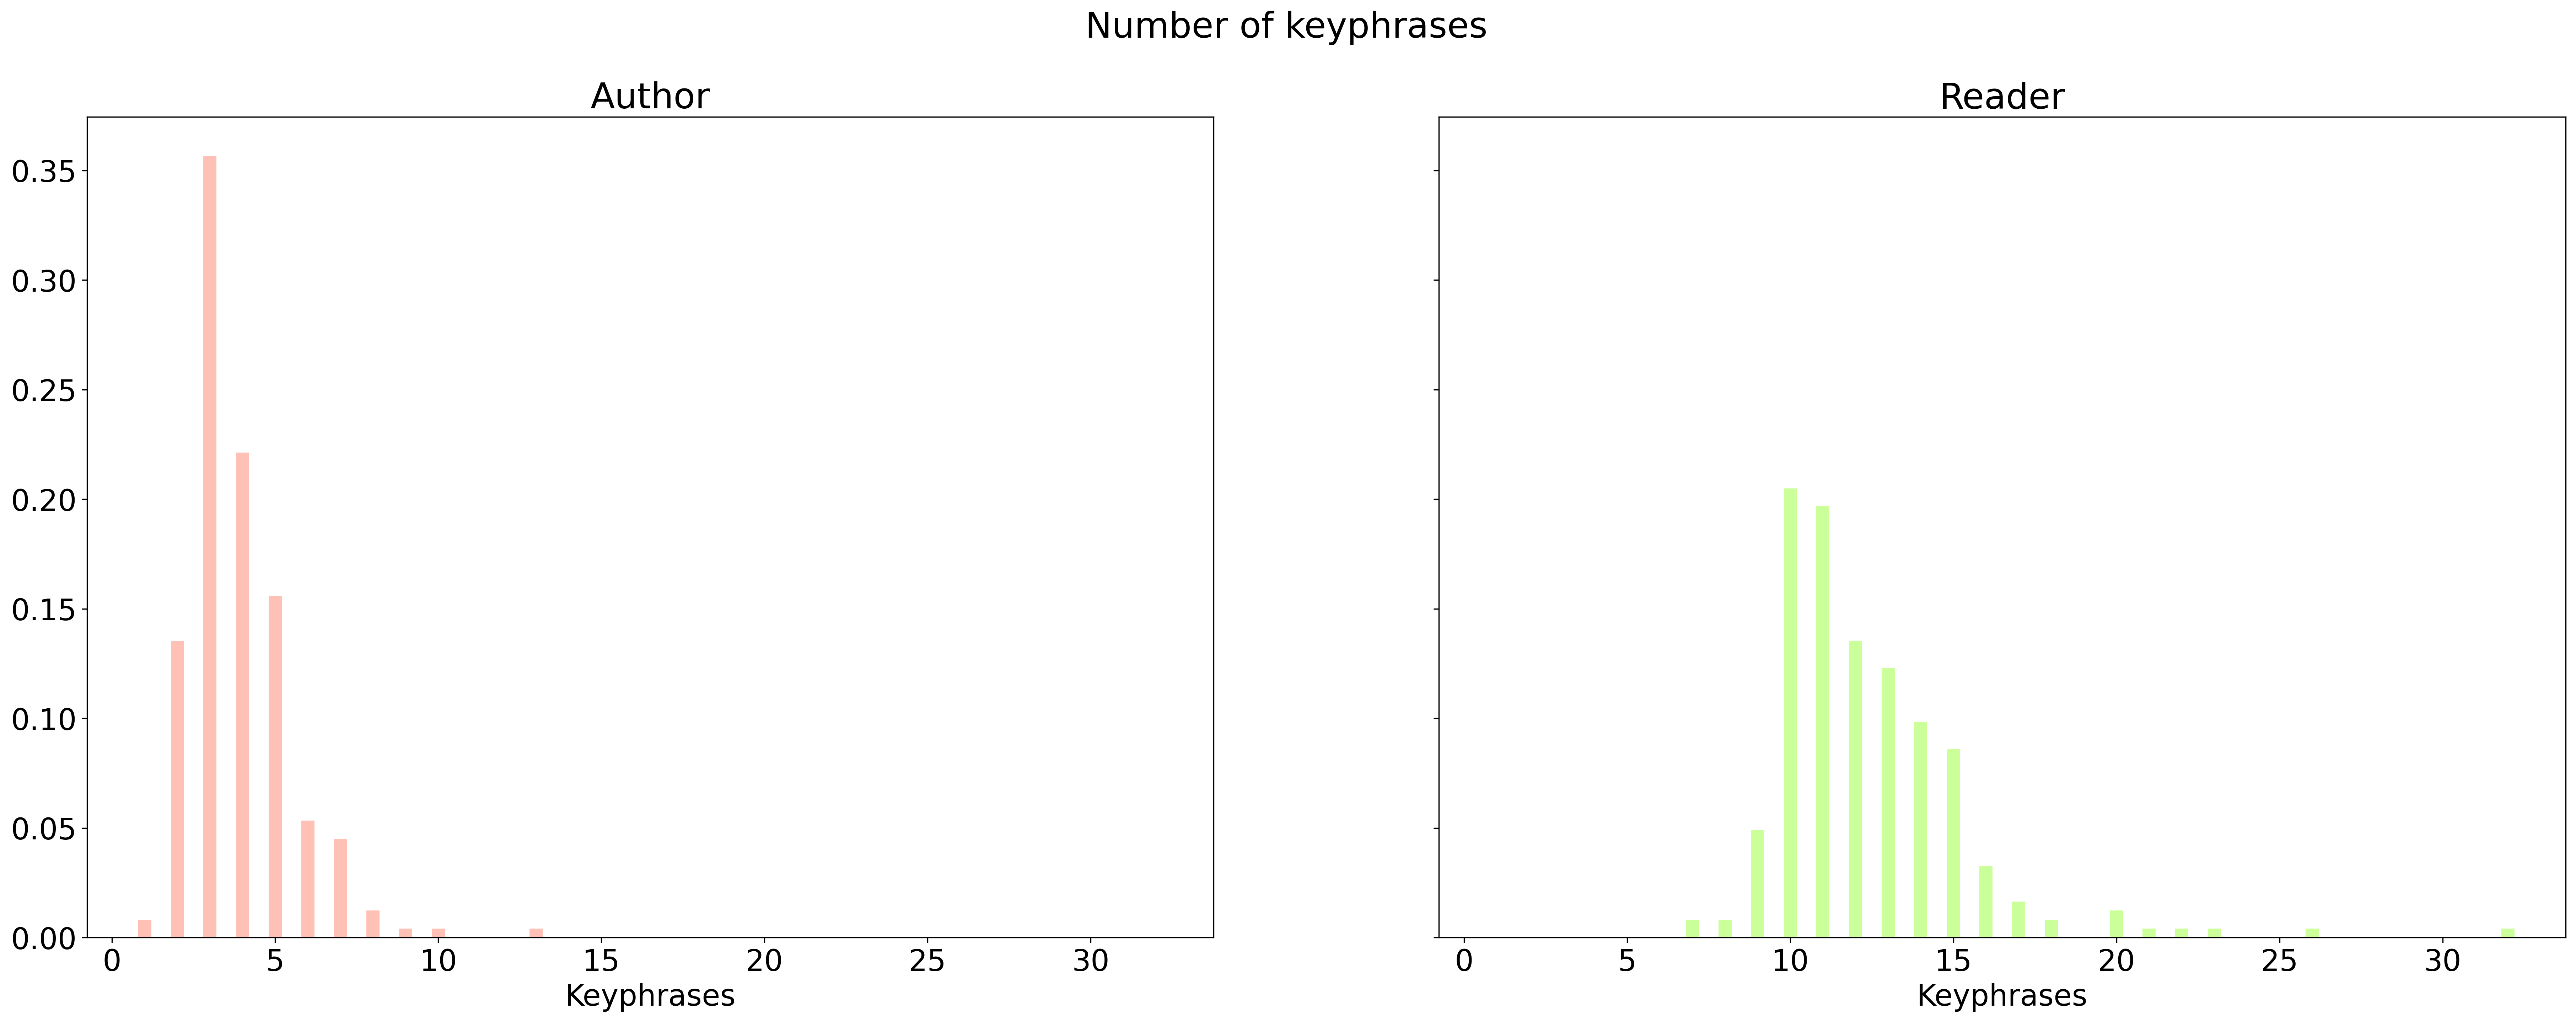

In [15]:
x_author = Counter([len(keyphrase.split(';')) for keyphrase in table_output.loc[table_output['subset_id'] == 'author', 'output']])
x_reader = Counter([len(keyphrase.split(';')) for keyphrase in table_output.loc[table_output['subset_id'] == 'reader', 'output']])

n_author = sum(x_author.values())
n_reader = sum(x_reader.values())

figure, axis = plt.subplots(nrows = 1, ncols = 2, figsize = (30, 10), dpi = 300, sharey = True, sharex = True)
plt.rcParams.update({'font.size': 20})

axis[0].bar(x_author.keys(), [x / n_author for x in x_author.values()], 0.4, alpha = 0.4, color = 'tomato', label = 'author')
axis[1].bar(x_reader.keys(), [x / n_reader for x in x_reader.values()], 0.4, alpha = 0.4, color = 'chartreuse', label = 'reader')

axis[0].set_xlabel('Keyphrases')
axis[1].set_xlabel('Keyphrases')

axis[0].set_title('Author')
axis[1].set_title('Reader')
figure.suptitle('Number of keyphrases')

plt.show()

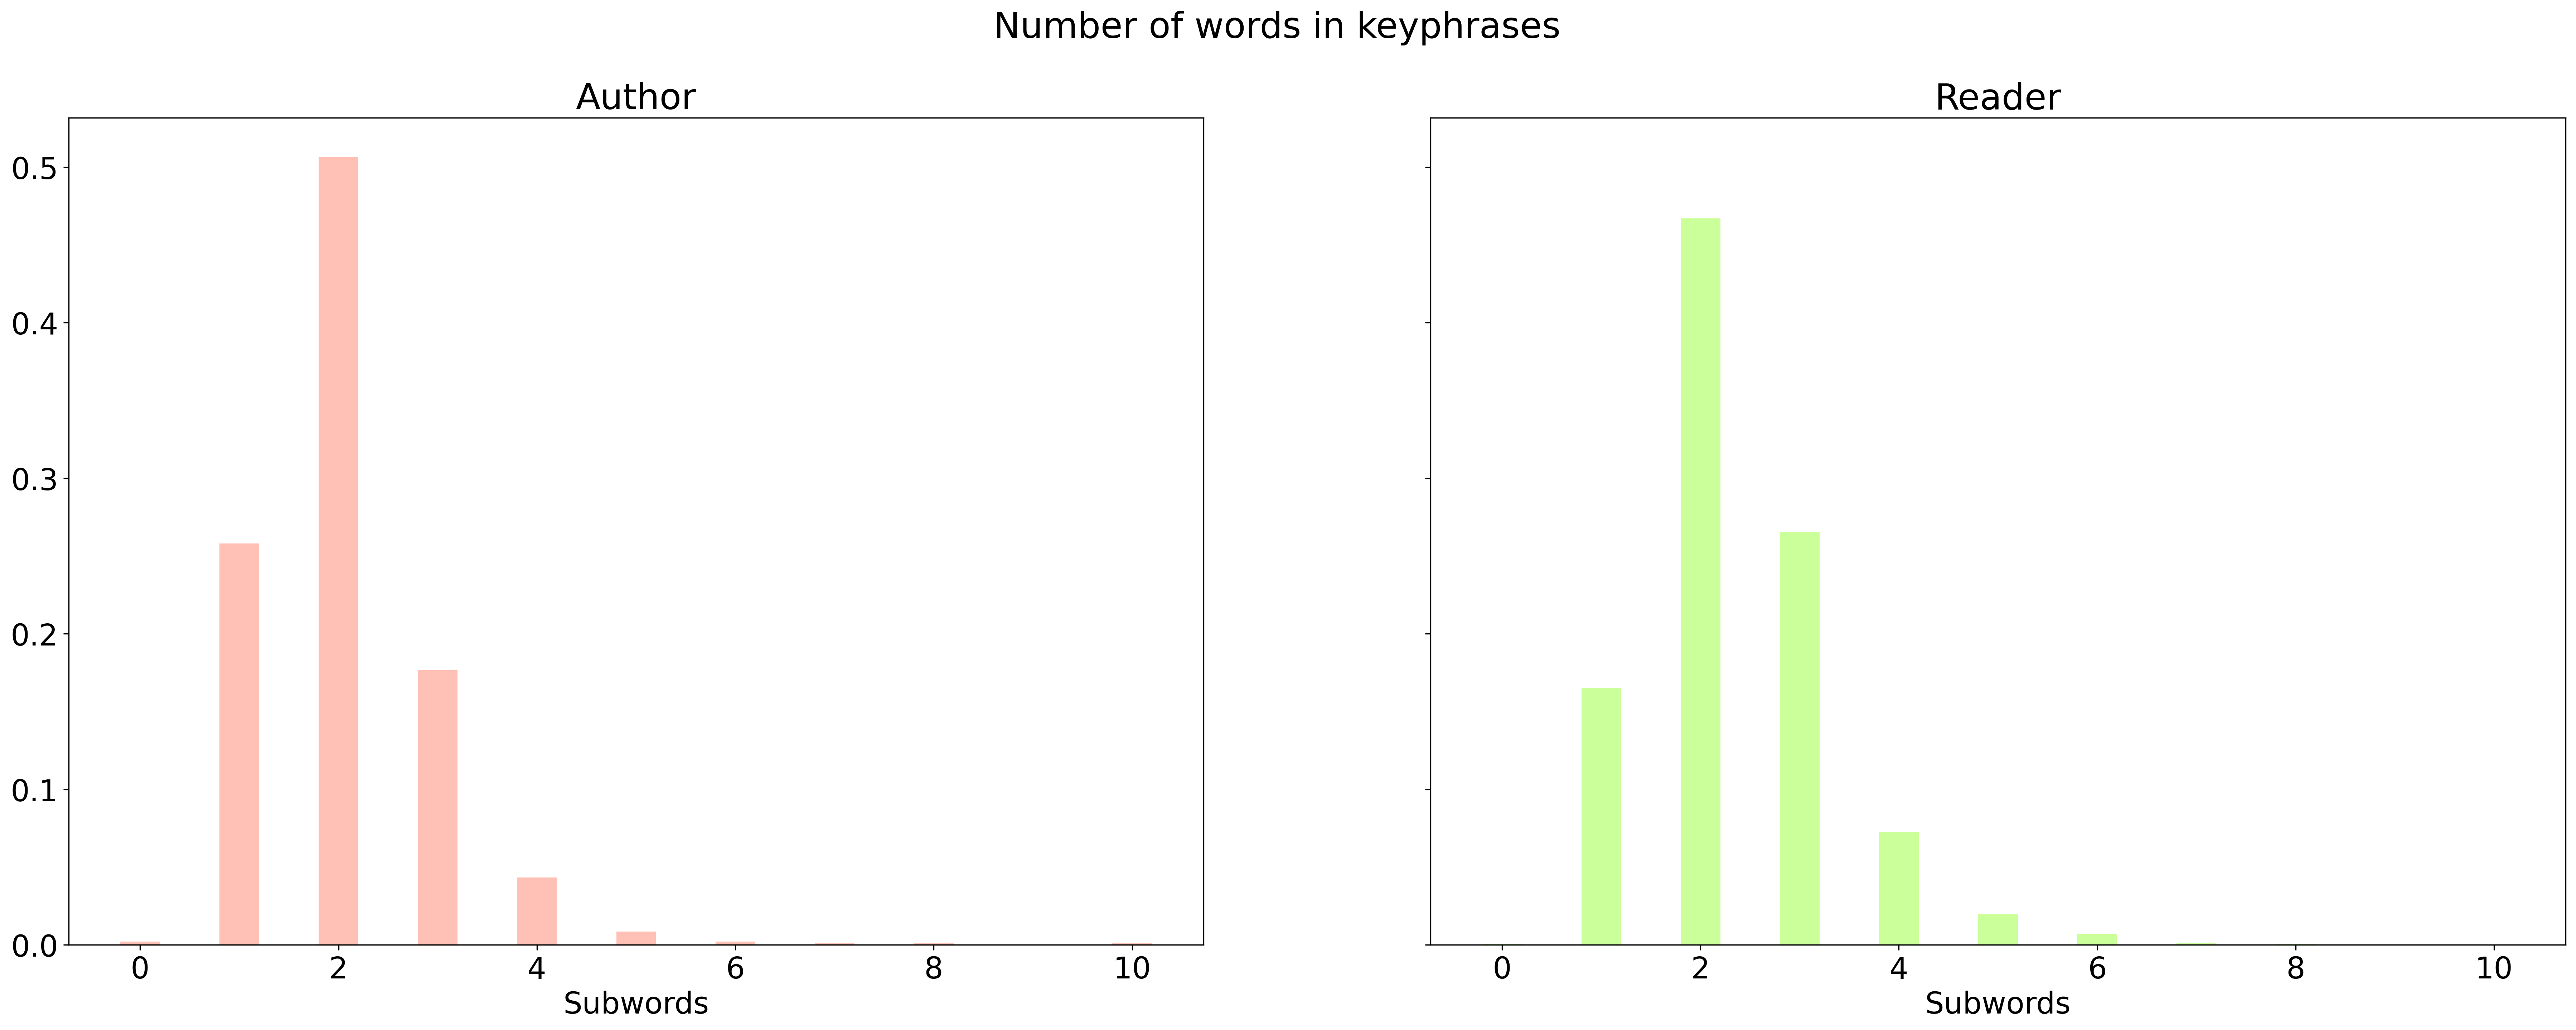

In [16]:
x_author = Counter([len([word for word in keyword.split()]) for keyphrase in table_output.loc[table_output['subset_id'] == 'author', 'output'] for keyword in keyphrase.split(';') ])
x_reader = Counter([len([word for word in keyword.split()]) for keyphrase in table_output.loc[table_output['subset_id'] == 'reader', 'output'] for keyword in keyphrase.split(';') ])

n_author = sum(x_author.values())
n_reader = sum(x_reader.values())

figure, axis = plt.subplots(nrows = 1, ncols = 2, figsize = (30, 10), dpi = 300, sharey = True, sharex = True)
plt.rcParams.update({'font.size': 20})

axis[0].bar(x_author.keys(), [x / n_author for x in x_author.values()], 0.4, alpha = 0.4, color = 'tomato', label = 'author')
axis[1].bar(x_reader.keys(), [x / n_reader for x in x_reader.values()], 0.4, alpha = 0.4, color = 'chartreuse', label = 'reader')

axis[0].set_xlabel('Subwords')
axis[1].set_xlabel('Subwords')

axis[0].set_title('Author')
axis[1].set_title('Reader')
figure.suptitle('Number of words in keyphrases')

plt.show()

### Exporting dataset<a class="anchor" id="semevalC"></a>

In [17]:
print('Example of an input:')
print(table_input.loc[0, 'input'])
print()
print('Example of an output:')
print(table_output.loc[0, 'output'])

Example of an input:
scalable grid service discovery based on uddi. efficient discovery of grid services is essential for the success of grid computing. the standardization of grids based on web services has resulted in the need for scalable web service discovery mechanisms to be deployed in grids even though uddi has been the de facto industry standard for web services discovery imposed requirements of tight replication among registries and lack of autonomous control has severely hindered its widespread deployment and usage. with the advent of grid computing the scalability issue of uddi will become a roadblock that will prevent its deployment in grids. in this paper we present our distributed web service discovery architecture called dude distributed uddi deployment engine. dude leverages dht distributed hash tables as a rendezvous mechanism between multiple uddi registries. dude enables consumers to query multiple registries still at the same time allowing organizations to have auto

In [18]:
if variables['USE_GCP'] != "false":
    list_bq_datasets = list(client.list_datasets())
    if variables['DATASET_ID'] not in [x.dataset_id for x in list_bq_datasets]:
        bq_dataset = bigquery.Dataset(f"{variables['PROJECT_ID']}.{variables['DATASET_ID']}")
        bq_dataset = client.create_dataset(
            bq_dataset, 
            timeout=30
        )
        print(f"Created dataset {variables['PROJECT_ID']}.{variables['DATASET_ID']}")
    else :
        print(f"Dataset {variables['PROJECT_ID']}.{variables['DATASET_ID']} already exists.")
    
    job = client.load_table_from_dataframe(
        dataframe = table_input, 
        destination = f"{variables['PROJECT_ID']}.{variables['DATASET_ID']}.{variables['TABLE_INPUT_ID']}"
    )
    job.result()

    job = client.load_table_from_dataframe(
        dataframe = table_output, 
        destination = f"{variables['PROJECT_ID']}.{variables['DATASET_ID']}.{variables['TABLE_OUTPUT_ID']}"
    )
    job.result()
else:
    try:
        current_inputs = pandas.read_csv(f"{variables['TABLE_INPUT_ID']}.csv", sep=",")
        current_outputs = pandas.read_csv(f"{variables['TABLE_OUTPUT_ID']}.csv", sep=",")
    except:
        current_inputs = pandas.DataFrame()
        current_outputs = pandas.DataFrame()
    current_inputs = pandas.concat([current_inputs, table_input]).drop_duplicates().reset_index(drop=True)
    current_outputs = pandas.concat([current_outputs, table_output]).drop_duplicates().reset_index(drop=True)
    current_inputs.to_csv(f"{variables['TABLE_INPUT_ID']}.csv", sep=",", index=False)
    current_outputs.to_csv(f"{variables['TABLE_OUTPUT_ID']}.csv", sep=",", index=False)

# TermITH-Eval<a class="anchor" id="termith"></a>
### Importing dataset<a class="anchor" id="termithA"></a>

In [19]:
dataset = 'TermITH-Eval'
folders = ['test']
remove_words = ['-rrb-', '-lrb-', '-lsb-', '-rsb-', '-lcb-', '-rcb-', '', ' ']

In [20]:
table_input = pandas.DataFrame()
for folder in folders :
    for file in sorted(listdir(f"{path}/{dataset}/{folder}")) :
        try :
            if '.xml' in file :
                document = parse(f"{path}/{dataset}/{folder}/{file}")
                text_input = ('. '.join([
                    ' '.join([
                        ' '.join([
                            subword for subword in tokenizer.tokenize(word.firstChild.nodeValue.lower())
                        ])
                        for word in sentence.getElementsByTagName('word') if word.firstChild.nodeValue.lower() not in remove_words
                    ]) 
                    for sentence in document.getElementsByTagName('sentence')
                ]) + '.').replace('  ', ' ').replace(' .', '.')

                table_input = pandas.concat([table_input,
                                       pandas.DataFrame({'dataset_id' : [f"{dataset.lower()}"],
                                                         'text_id' : [f"{folder}_{file.split('.xml')[0].replace('-','_')}"],
                                                         'input' : [text_input]})])
        except Exception as e :
            print('File:', file, 'has error:', e)
table_input = table_input.drop_duplicates().reset_index(drop=True)
table_input

,dataset_id,text_id,input
0,termith-eval,test_archeologie_08_0040093_tei,petit gibier et fonction de sites à le paléoli...
1,termith-eval,test_archeologie_08_0040094_tei,les fieux une occupation gravettienne de le ca...
2,termith-eval,test_archeologie_08_0040095_tei,l occupation de l aurignacien ancien de barbas...
3,termith-eval,test_archeologie_08_0040096_tei,le burin des vachons apports d une relecture t...
4,termith-eval,test_archeologie_08_0040097_tei,les couches supérieures de la micoque dordogne...
...,...,...,...
394,termith-eval,test_sciencesInfo_13_0090579_tei,aristote dit il encore quelque chose à le xxie...
395,termith-eval,test_sciencesInfo_13_0090580_tei,jeu de la mort ou jeu avec le feu. les leçons ...
396,termith-eval,test_sciencesInfo_13_0090584_tei,dire la mort écrire la vie. re présentations d...
397,termith-eval,test_sciencesInfo_13_0090586_tei,facebook mort ou vif. deuils intimes et causes...


In [21]:
table_output = pandas.DataFrame()
for folder in folders :
        keywords = {}
        with open(f'{path}/{dataset}/references/{folder}.indexer.json') as references_file :
            keywords.update(json.load(references_file))

        for key in keywords.keys() :
            keywords[key] = ';'.join([' '.join([subword.lower() for subword in tokenizer.tokenize(keyword) if subword not in remove_words and subword.isalpha()]) for keyword in [keyphrase[0] for keyphrase in keywords[key]]])
            table_output = pandas.concat([table_output,
                               pandas.DataFrame({'dataset_id' : [f"{dataset.lower()}"],
                                                 'subset_id' : [f"indexer"],
                                                 'text_id' : [f"{folder}_{key.replace('-','_')}"],
                                                 'output' : [keywords[key]]})])
table_output = table_output.drop_duplicates().reset_index(drop=True)
table_output

,dataset_id,subset_id,text_id,output
0,termith-eval,indexer,test_archeologie_08_0040093_tei,chalcolithique;europe;estremadure;anecrial;por...
1,termith-eval,indexer,test_archeologie_08_0040094_tei,europe;paléolithique supérieur;mésolithique;le...
2,termith-eval,indexer,test_archeologie_08_0040095_tei,europe;paléolithique moyen;paléolithique supér...
3,termith-eval,indexer,test_archeologie_08_0040096_tei,europe;paléolithique supérieur;france;le facte...
4,termith-eval,indexer,test_archeologie_08_0040097_tei,europe;paléolithique moyen;france;la micoque;o...
...,...,...,...,...
394,termith-eval,indexer,test_sciencesInfo_13_0090579_tei,discipline;rhétorique;aristote
395,termith-eval,indexer,test_sciencesInfo_13_0090580_tei,service public;expérience;programme télévision...
396,termith-eval,indexer,test_sciencesInfo_13_0090584_tei,lexique;analyse discours;représentation social...
397,termith-eval,indexer,test_sciencesInfo_13_0090586_tei,réseau social;mort;rédaction;mémoire;facebook;...


### Explanatory Data Analysis<a class="anchor" id="termithB"></a>

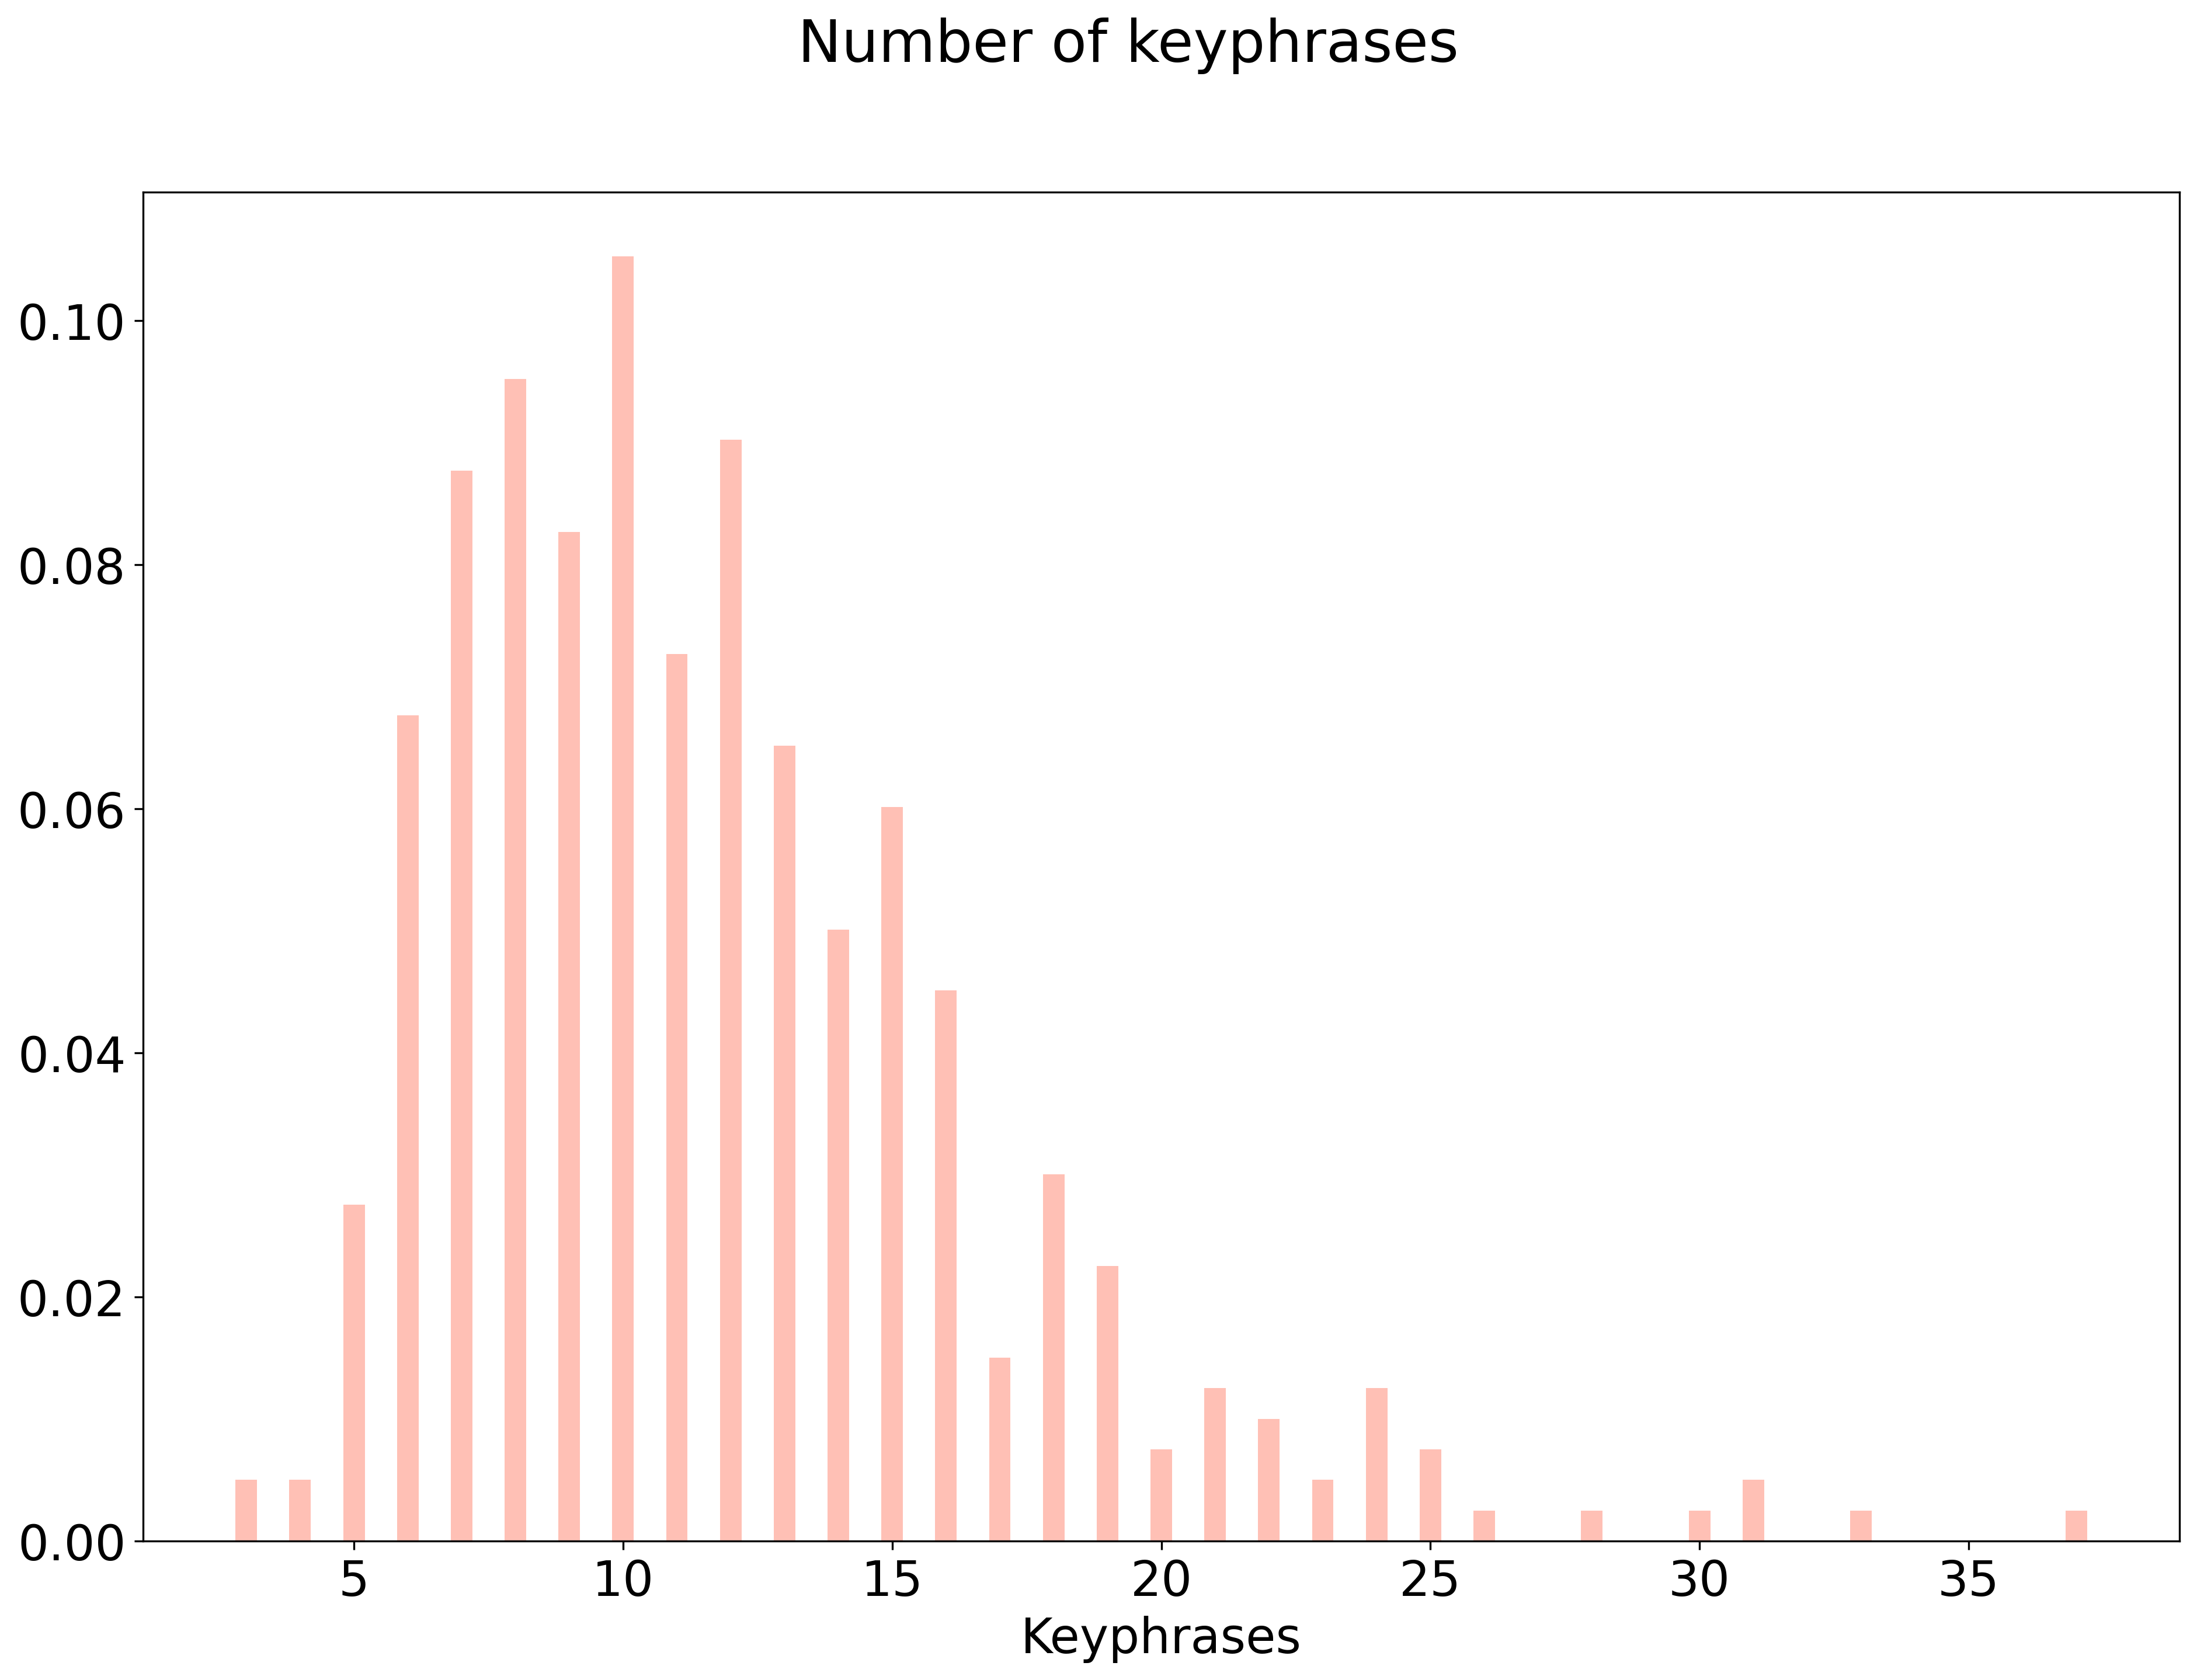

In [22]:
x = Counter([len(keyphrase.split(';')) for keyphrase in table_output['output']])

n = sum(x.values())

figure, axis = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 10), dpi = 300, sharey = True, sharex = True)
plt.rcParams.update({'font.size': 20})

axis.bar(x.keys(), [value / n for value in x.values()], 0.4, alpha = 0.4, color = 'tomato')

axis.set_xlabel('Keyphrases')

figure.suptitle('Number of keyphrases')

plt.show()

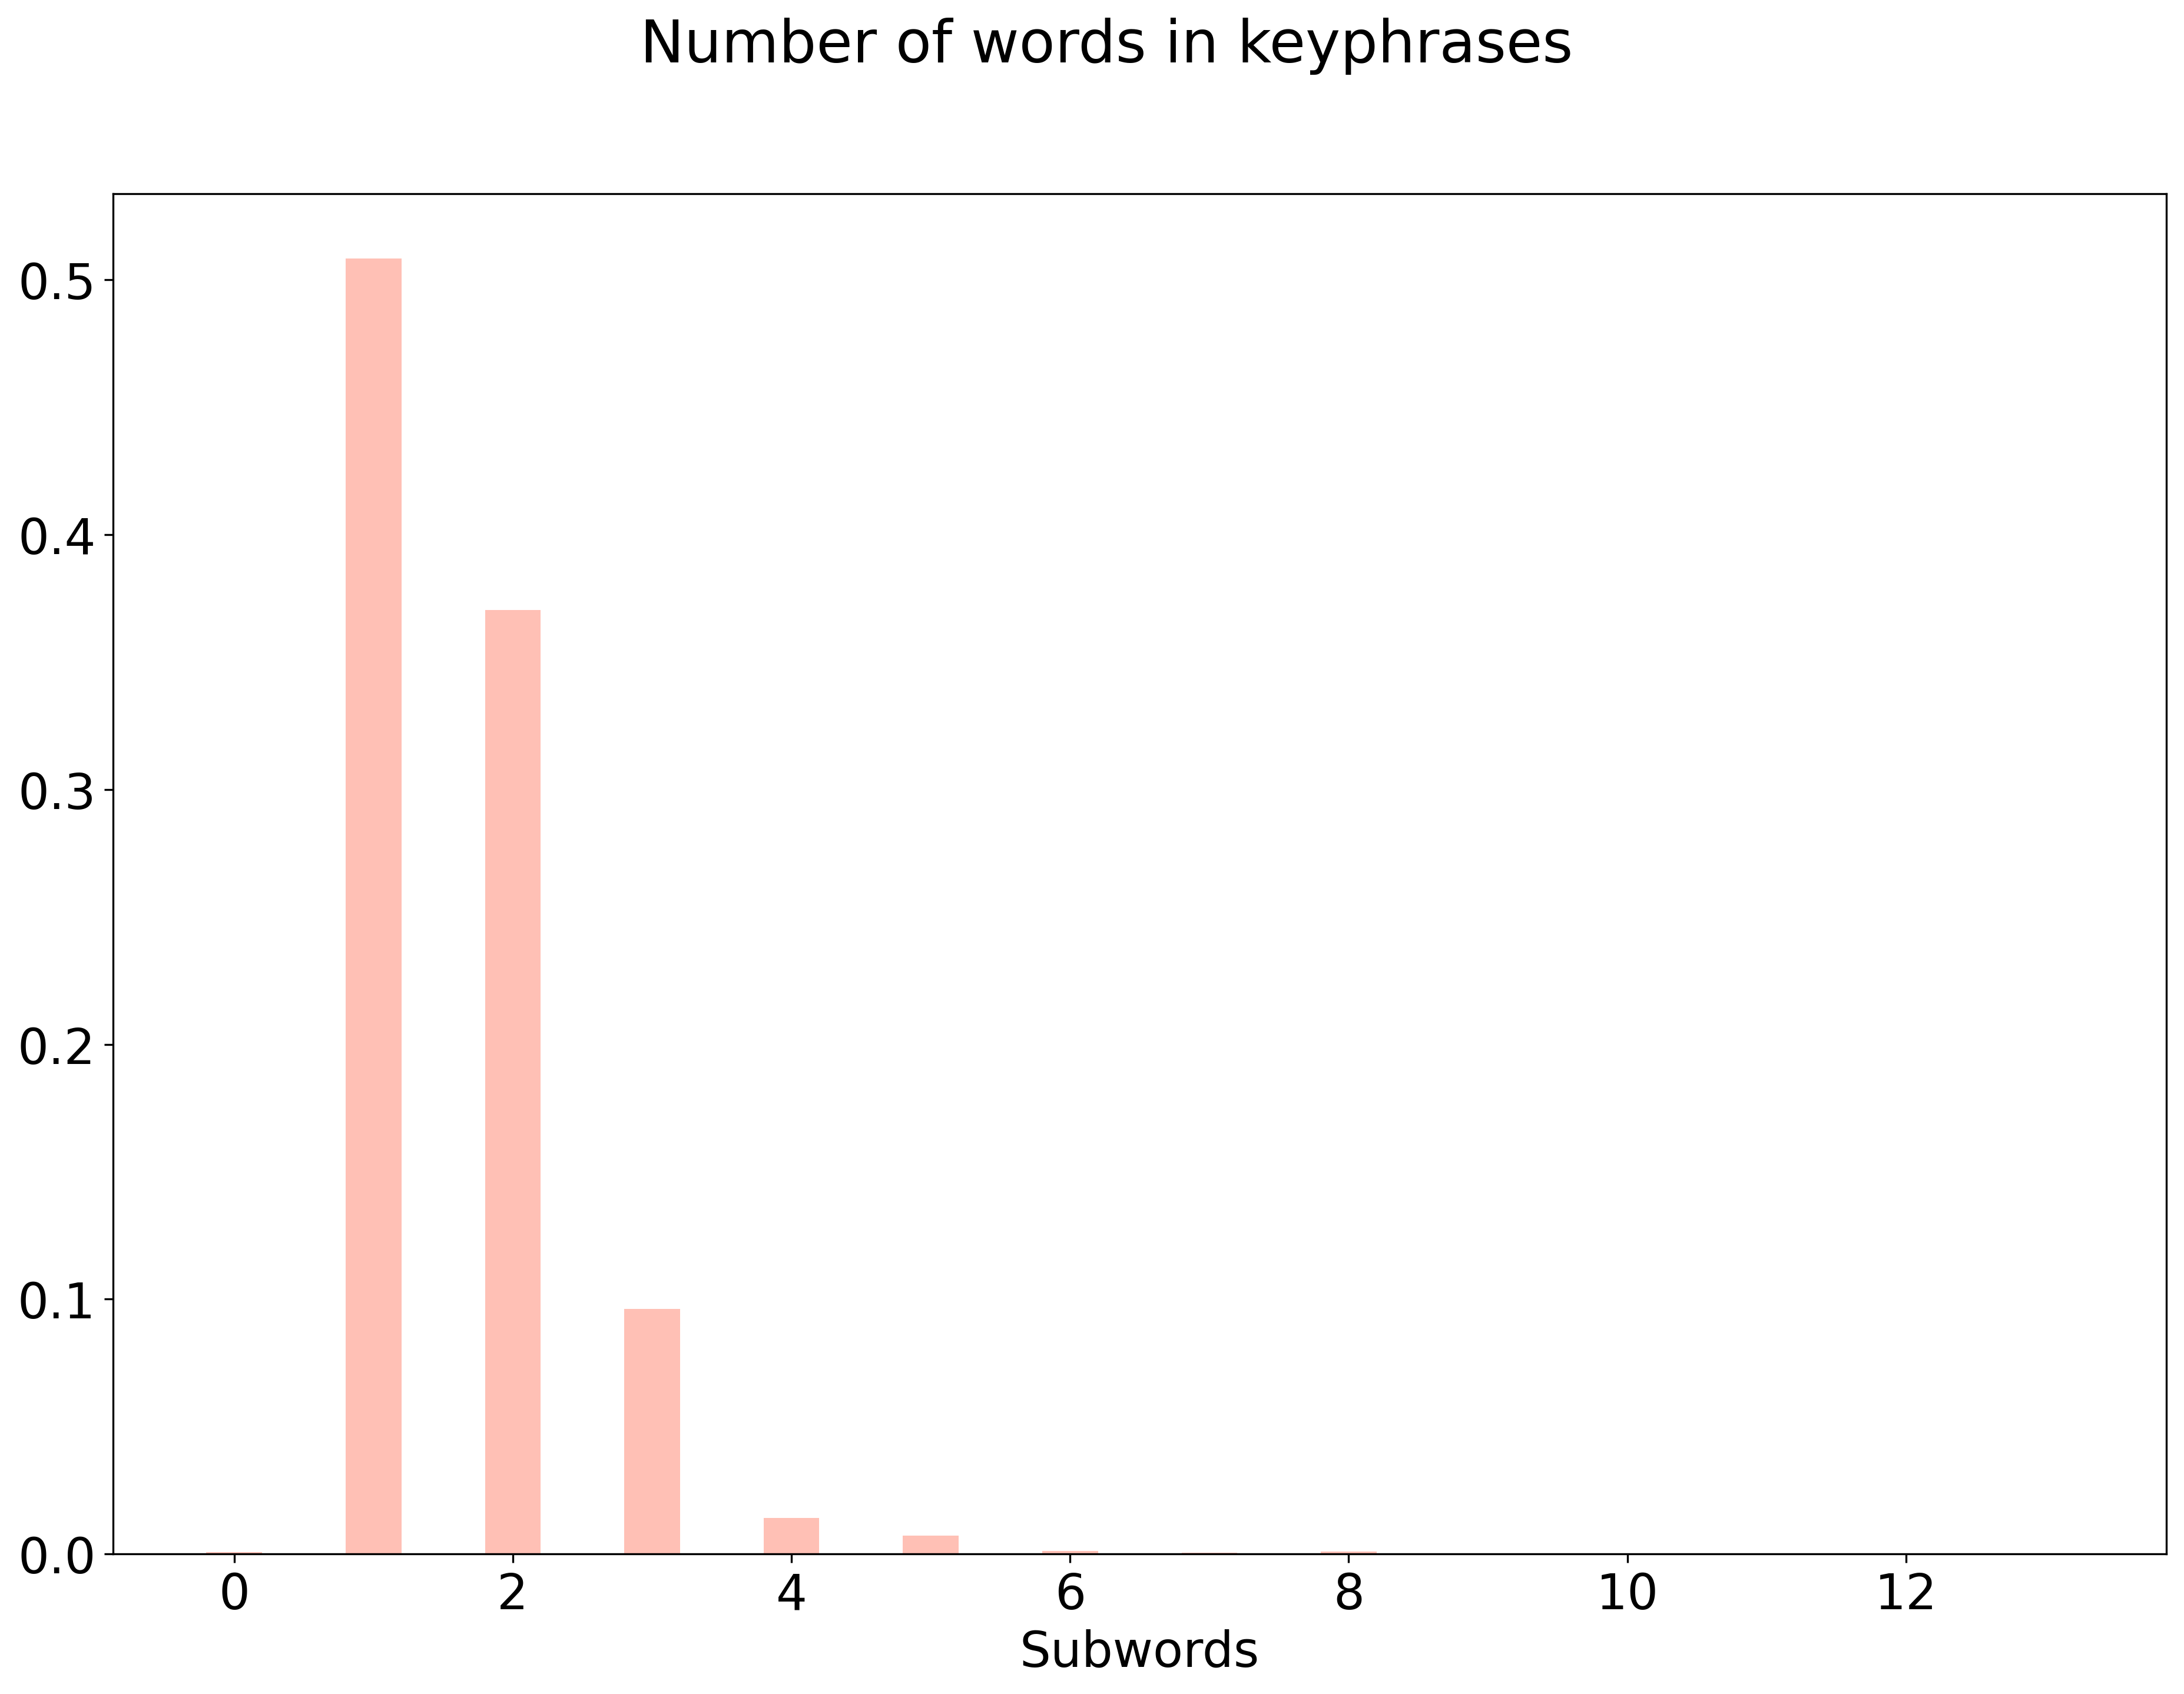

In [23]:
x = Counter([len([word for word in keyword.split()]) for keyphrase in table_output['output'] for keyword in keyphrase.split(';') ])

n = sum(x.values())

figure, axis = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 10), dpi = 300, sharey = True, sharex = True)
plt.rcParams.update({'font.size': 20})

axis.bar(x.keys(), [value / n for value in x.values()], 0.4, alpha = 0.4, color = 'tomato')

axis.set_xlabel('Subwords')

figure.suptitle('Number of words in keyphrases')

plt.show()

### Exporting dataset<a class="anchor" id="termithC"></a>

In [24]:
print('Example of an input:')
print(table_input.loc[0, 'input'])
print()
print('Example of an output:')
print(table_output.loc[0, 'output'])

Example of an input:
petit gibier et fonction de sites à le paléolithique supérieur les ensembles fauniques de la grotte d anecrial porto de mos estremadure portugal. le gisement en grotte d anecrial livre des ensembles fauniques dominés par les lagomorphes genre oryctolagus  représentés par peu d individus. la dispersion des restes les parties de le squelette et les types de fracturation cylindres précisent l origine de l accumulation et les hypothèses fonctionnelles de le site. le gisement est interprété comme un bivouac utilisé à le moins à trois reprises par un groupe humain réduit orienté vers l acquisition spécifique de ce petit gibier. la comparaison avec d autres gisements met en évidence l importance des léporidés dans l alimentation des hommes de le paléolithique supérieur moyen et final en particulier à le portugal et aborde les relations entre des facteurs environnementaux et des modèles socio économiques humains.

Example of an output:
chalcolithique;europe;estremadure;ane

In [25]:
if variables['USE_GCP'] != "false":
    list_bq_datasets = list(client.list_datasets())
    if variables['DATASET_ID'] not in [x.dataset_id for x in list_bq_datasets]:
        bq_dataset = bigquery.Dataset(f"{variables['PROJECT_ID']}.{variables['DATASET_ID']}")
        bq_dataset = client.create_dataset(
            bq_dataset, 
            timeout=30
        )
        print(f"Created dataset {variables['PROJECT_ID']}.{variables['DATASET_ID']}")
    else :
        print(f"Dataset {variables['PROJECT_ID']}.{variables['DATASET_ID']} already exists.")
    
    job = client.load_table_from_dataframe(
        dataframe = table_input, 
        destination = f"{variables['PROJECT_ID']}.{variables['DATASET_ID']}.{variables['TABLE_INPUT_ID']}"
    )
    job.result()

    job = client.load_table_from_dataframe(
        dataframe = table_output, 
        destination = f"{variables['PROJECT_ID']}.{variables['DATASET_ID']}.{variables['TABLE_OUTPUT_ID']}"
    )
    job.result()
else:
    try:
        current_inputs = pandas.read_csv(f"{variables['TABLE_INPUT_ID']}.csv", sep=",")
        current_outputs = pandas.read_csv(f"{variables['TABLE_OUTPUT_ID']}.csv", sep=",")
    except:
        current_inputs = pandas.DataFrame()
        current_outputs = pandas.DataFrame()
    current_inputs = pandas.concat([current_inputs, table_input]).drop_duplicates().reset_index(drop=True)
    current_outputs = pandas.concat([current_outputs, table_output]).drop_duplicates().reset_index(drop=True)
    current_inputs.to_csv(f"{variables['TABLE_INPUT_ID']}.csv", sep=",", index=False)
    current_outputs.to_csv(f"{variables['TABLE_OUTPUT_ID']}.csv", sep=",", index=False)